# This is the analysis and plottign script for the IF gastruloid data 

Examplary analysis of the plots shown in Fig 6 C-H and S8 B-I using the data frames extracted from the previous IF analysis scripts, the one stored on Zenodo, or an examplary data frame stored in this repo.



### Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.lines import Line2D

cwd = os.getcwd()
modules = cwd.replace('/exe/IF_analysis', '')
sys.path.insert(1, modules)

import modules.configs_setup as configs
import modules.processed_data_analysis as pda

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.use14corefonts'] = True

### Set configurations and plotting parameter

In [2]:
# big analysis folder with all data and configs folder
raw_data_folder = cwd+'/'

# load configs
cnfgs = configs.load_configs(raw_data_folder) 

# load data
df_all = pda.load_processed_df(raw_data_folder + cnfgs['merged']['savename'] , all=True)

# load plotting params
plot_params = configs.load_default_plot_params()


for p,v in plot_params['rcParams'].items():
    rcParams[p] = v
    
fig_format = plot_params['format']
color_dict_sizes = plot_params['color_dict_sizes']
line_style_dict = plot_params['line_style_dict']
exp_dict = plot_params['exp_color_dict']
exp_idxs = plot_params['exp_idxs']
ls_dict = plot_params['exp_ls_dict']
plots_path = raw_data_folder + cnfgs['plots_folder']

sorted_groups = ['50', '50x6', '300', '1200/4', '300x4', '1200', '3000']
ls_dict_sizes = {'50': ':','50x6': '-','300': '-','1200/4': '-','300x4': '--','1200': '--','3000': '-'}
ls_exp_dict = {'231030_BG06': ':','230903_Exp5_SlowImaging': '--','240202_size_50-1200': '-.','240205_size_50-1200': '-'}

Loaded 2025-01-14_configs.yml.
# rows:  395


In [3]:
# flip the profiles along AP axis
df_profiles_oriented = df_all.copy()
channels = ['DAPI', 'Sox2', 'Bra', 'Foxc1']
channels_to_flip = ['DAPI', 'DAPI_area_norm', 'Sox2', 'Sox2_area_norm', 
                    'Bra', 'Bra_area_norm', 'Foxc1', 'Foxc1_area_norm']
df_profiles_oriented  = pda.flip_profiles(df_all, channels=channels_to_flip, bool_col_name='correct_orientation')
df_profiles_oriented = pda.convert_16_to_8_bit(df_profiles_oriented, channels)

# Start the ananlysis

## Compare different $N_0$ conditions for one experiment

### Fig S8 E 

Mean expression profiles of Bra, Foxc1, and Sox2 at 120 h or 144 h, showing variability between conditions within a single experiment. Vertical lines indicate relative pattern boundary positions ($x_b/L$) of the mean profiles marked at the half-maximal expression value (EC50).

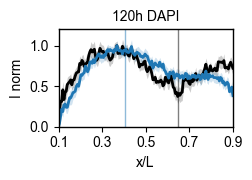

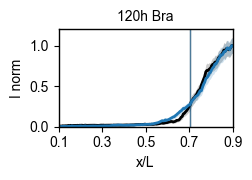

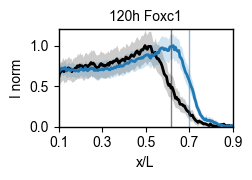

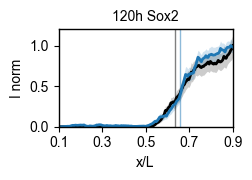

In [4]:
## for each experiment separately
####
exp ='240205_size_50-1200'
###


for chan in ['DAPI', 'Bra', 'Foxc1', 'Sox2']:
    dfOI, _ = pda.normalize_data_by_exp_mean(df_profiles_oriented, chan, exp, 
                                             filter_cond=['3000', '300x4', '1200/4', '50x6'])
    
    
    fig, ax = plt.subplots(1,1, figsize=(2.7, 1.9))
        
    t = 120
    df_t = dfOI[dfOI['time']==t]
    
    for i, s in enumerate(sorted(df_t.final_size.unique())):
        df_s = df_t[df_t['final_size'] == s]
        color = color_dict_sizes[str(s)]
        exp_color=exp_dict[exp]
        
        if len(df_s) < 3:
            continue
            
        if s == 1200:
            color = 'C02'
            
        if s == 300:
            color = 'C00'
        
        if s == 3000:
            color = 'C03'
        
        m = pda.get_meanprofile(df_s, [f'{chan}_mean_exp_norm'])
        mean = m[f'{chan}_mean_exp_norm']
        x = np.linspace(0, 1, len(mean))
        xs = x[round(0.1*len(x)):-round(0.1*len(x))]
        mean = mean[round(0.1*len(x)):-round(0.1*len(x))]
        
        std = pda.get_stdprofile(df_s, [f'{chan}_mean_exp_norm'])
        se = std[f'{chan}_mean_exp_norm'] / (len(df_s)**0.5)
        se = se[round(0.1*len(x)):-round(0.1*len(x))]
        
        ##### cutoff on profiles
        
        ax.plot(xs, mean, lw=2, label=s, color=color)
        ax.fill_between(xs, mean-se, mean+se, color=color, alpha=0.2, lw=0)
        
        xmin=0.1
        gradient_ch = 2
        if chan == 'Foxc1':
            xmin=0.42
            gradient_ch = -2
        
        try:
            xboundary, Iboundary = pda.findboundary_extrema(mean, k=3, xmin=xmin, xmax=1, gradient=gradient_ch) 
            xb = np.mean(xboundary)
            ax.axvline(x=xs[int(xb)], ymin=0, ymax=1, color=color, alpha=0.5)   
                
        except:
            print(s)
        
            
    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xlabel('x/L')
    ax.set_ylabel('I norm')
    ax.set_title(f'{t}h {chan}')
    ax.set_ylim(0,1.2)
    ax.set_xlim(0.1,0.9)
    #ax.legend(frameon=False)
    
        
    fig.tight_layout()
    #plt.savefig(plots_path+ f'{chan}_{exp}_dynamic_range_small.svg', dpi=200, transparent=True)
    plt.show()

## Compare different $N_0$ conditions across all experiments

### Fig 6C, S8 B, S9 B-D

Normalized expression profiles (means ± s.e.m.) of a channel (Foxc1, Bra, Sox2) at 120 h and 144 h for gastruloids with the same N0, plotted as a function of the relative position (x/L) along the average midline. Data from four experimental batches are shown in the same plot. AP-axis is oriented left-to-right (0 = anterior pole, 1 = posterior pole). 

In [5]:
chan = 'Foxc1'

df = df_profiles_oriented 
# set up new data frames to match intensity value scale
new_df_8bit = df_profiles_oriented.copy()

for exp in df_profiles_oriented.expID.unique():
    df_e = df_profiles_oriented[df_profiles_oriented['expID']==exp]
    matrix = np.ndarray((len(df_e), 194))
    for i, ix in enumerate(df_e.index):
        if not '2402' in exp:
            data_ch = np.divide(np.array(df_e.at[ix, f'{chan}'], dtype=float), 256 )
            data_dapi = np.divide(np.array(df_e.at[ix, f'DAPI'], dtype=float), 256 )
            data_ch_norm = np.divide(np.array(df_e.at[ix, f'{chan}_area_norm'], dtype=float) , 256 )
            data_dapi_norm = np.divide(np.array(df_e.at[ix, f'DAPI_area_norm'], dtype=float) , 256 )
            new_df_8bit.at[ix, f'{chan}'] = data_ch
            new_df_8bit.at[ix, f'DAPI'] = data_dapi
            new_df_8bit.at[ix, f'{chan}_area_norm'] = data_ch_norm
            new_df_8bit.at[ix, f'DAPI_area_norm'] = data_dapi_norm
                                       

df = new_df_8bit        
df = df[df['group'] != '3000']
df = df[df['cut-fused'] != 'Yes'] 


### get dictionary of min max values per condition (0.1 offset)
min_max_dict = {}
mean_profile_dict = {}

for exp in df.expID.unique():
    df_e = df[df['expID']==exp]
    
    for t in df_e.time.unique():
        df_t = df_e[df_e['time']==t]
        
        for i, s in enumerate(sorted(df_t.final_size.unique())):
            df_s = df_t[df_t['final_size'] == s]
            
            if len(df_s) < 3:
                continue
            
            mean_profile_dict[f'{t}-{s}'] = pda.get_meanprofile(df_s, [f'{chan}_area_norm'])
            l = len(mean_profile_dict[f'{t}-{s}'][f'{chan}_area_norm'])
            profile = mean_profile_dict[f'{t}-{s}'][f'{chan}_area_norm'][round(l*0.1):-round(l*0.1)]
    
            minI, maxI = np.nanmin(profile), np.nanmax(profile)
            min_max_dict[f'{exp}-{chan}-{t}-{s}'] = minI, maxI
        

        
## normalize each gastruloids profile by exp min max and save data in data frame (already taking cutoff)
df[f'{chan}_mean_exp_norm'] = df[f'{chan}']


for exp in df.expID.unique():
    df_e = df[df['expID']==exp]
    
    for t in df_e.time.unique():
        df_t = df_e[df_e['time']==t]
    
        for i, s in enumerate(sorted(df_t.final_size.unique())):
            df_s = df_t[df_t['final_size'] == s]
            
            if len(df_s) < 3:
                continue
                    
            xs = np.linspace(0, 1, len(df_s.at[df_s.index[0], f'{chan}_area_norm']))
            lm = len(xs)
            minI, maxI = min_max_dict[f'{exp}-{chan}-{t}-{s}']
            
            
            for ix in df_s.index:
                p = df_s.at[ix, f'{chan}_area_norm']    
                p = np.array(p, dtype=float)
                norm_p = (p - minI) / (maxI - minI)
                
                df.at[ix, f'{chan}_mean_exp_norm'] = norm_p[round(lm*0.1):-round(lm*0.1)] 
    

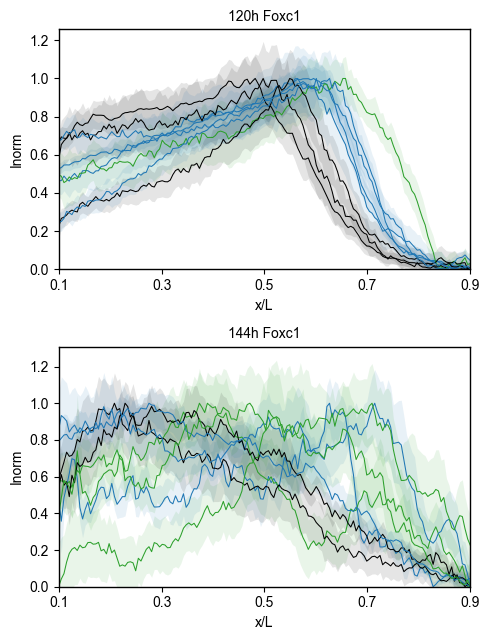

In [6]:
fig, axes = plt.subplots(2,1, figsize=(5, 6.5))

    
for ax, t in zip(axes.flatten(), df.time.unique()):
    
    df_t = df[df['time']==t]
    
    for exp in df.expID.unique():
        df_e = df_t[df_t['expID'] == exp]
    
    
        for i, s in enumerate(sorted(df_e.final_size.unique())):
            
            df_s = df_e[df_e['final_size'] == s]
            color = color_dict_sizes[str(s)]
            if s == 1200:
                color = 'C02'
                
            if s == 300:
                color = 'C00'
                
            ls = ls_dict_sizes[str(s)]
            exp_color=exp_dict[exp]
            exp_ls = ls_exp_dict[exp]
            
            if len(df_s) < 3:
                continue
                
            
            m = pda.get_meanprofile(df_s, [f'{chan}_mean_exp_norm'])
            mean = m[f'{chan}_mean_exp_norm']
            xs = np.linspace(0.1, 0.9, len(mean))
            
            std = pda.get_stdprofile(df_s, [f'{chan}_mean_exp_norm'])
            se = std[f'{chan}_mean_exp_norm'] / (len(df_s)**0.5)
            
    
            ax.plot(xs, mean, lw=0.75, label=f'{s}', color=color)
            ax.fill_between(xs, mean+se,mean-se, color=color, alpha=0.1,lw=0)
            
            
    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xlabel('x/L')
    ax.set_ylabel('Inorm')
    ax.set_title(f'{t}h {chan}')
    
    custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='C00', lw=4),
                Line2D([0], [0], color='C02', lw=4)]
    
    
    #ax.legend(custom_lines, ['50', '300', '1200'], frameon=False, )
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlim(0.1, 0.9)
    
fig.tight_layout()
plots_path = '/Users/ph6877/Desktop/IF_analysis/plots/'
plt.savefig(plots_path+ f'{chan}_{exp}_dynamic_range_se2.svg', dpi=200, transparent=True)
plt.show()

## Comparison of size perturbed (cut and fuse) and unperturbed condition per experiment

### Fig 6E,F, S8F insets

Normalized mean expression profiles as a function of average absolute position along the anterior-posterior midline.

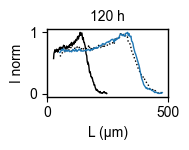

In [7]:
# raw intensities normalized be area of segment, over L

t = 120
chan = 'Foxc1'
exps = ['240205_size_50-1200']

#exclude = ['3000', '50', '300x4', '50x6']
exclude = ['3000', '1200/4','1200', '300x4',]
#exclude = ['3000', '50', '50x6', '1200/4',]
#exclude = ['3000']

mean_profile_dict = {}

boundary_dict_c = {}
for exp in exps:
    dfOI, _ = pda.normalize_data_by_exp_mean(df_profiles_oriented, chan=chan, exp=exp, filter_cond=exclude)
    
        
    fig, ax = plt.subplots(figsize=(2,1.6))
    
    df_t = dfOI[dfOI['time']==t]
    for i, s in enumerate(sorted_groups):
        df_s = df_t[df_t['group'] == s]
        color = color_dict_sizes[str(s)]
        
        if len(df_s) < 3:
                continue
        
        ls = '-'
        if df_s['cut-fused'].unique()[0] == 'Yes':
            ls = ':'
            
        if s in ['1200', '1200/4']:
            color = 'C02'
            
        if s in ['300', '300x4', ]:
            color = 'C00'
            
        if s in ['50', '50x6']:
            color = 'k'
            
        if s == '3000':
            color = 'C03'
            
            
            
        meanL = np.nanmean(df_s[f'Length_MA_um'])
        y = df_s.at[df_s.index[0], f'{chan}_mean_exp_norm']
        x = np.linspace(0, meanL, len(y))
        
        mean_profile_dict[f'{t}-{s}'] = pda.get_meanprofile(df_s, [f'{chan}_mean_exp_norm'])
        mean = mean_profile_dict[f'{t}-{s}'][f'{chan}_mean_exp_norm']
        
        xcut = x[int(len(x)*0.1):int(len(x)*0.9)]
        meancut = mean[int(len(x)*0.1):int(len(x)*0.9)]
        
        ax.plot(xcut, meancut, lw=1, label=f'{s}, N: {len(df_s)}', 
                color=color, ls=ls)
        
    ax.set_title(f'{t} h')
    ax.set_xlabel('L (µm)')
    ax.set_ylabel('I norm')
    ax.set_xlim(left=0)
        
    
    fig.tight_layout()       
    #plt.savefig(plots_path+ f'{exp}_{chan}_norm_perturbed_fuse.svg', dpi=200, transparent=True)
    plt.show()
    
    

### Fig 6E,F, S8F

Expression profiles of a channel (Foxc1, Bra, Sox2) at 120 h or 144 h, comparing perturbed (dashed lines) and control (solid lines) conditions.

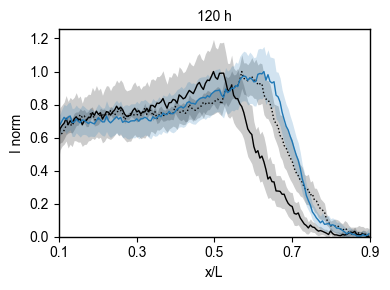

In [8]:
# raw intensities normalized be area of segment, over L

t = 120
chan = 'Foxc1'
exps = ['240205_size_50-1200']

#exclude = ['3000', '50', '300x4', '50x6']
exclude = ['3000', '1200/4','1200', '300x4',]
#exclude = ['3000', '50', '50x6', '1200/4',]
#exclude = ['3000']

mean_profile_dict = {}

boundary_dict_c = {}
for exp in exps:
    dfOI, _ = pda.normalize_data_by_exp_mean(df_profiles_oriented, chan=chan, exp=exp, filter_cond=exclude)
    
        
    fig, ax = plt.subplots(figsize=(4,3))
    
    df_t = dfOI[dfOI['time']==t]
    for i, s in enumerate(sorted_groups):
        df_s = df_t[df_t['group'] == s]
        color = color_dict_sizes[str(s)]
        
        if len(df_s) < 3:
                continue
        
        ls = '-'
        if df_s['cut-fused'].unique()[0] == 'Yes':
            ls = ':'
            
        if s in ['1200', '1200/4']:
            color = 'C02'
            
        if s in ['300', '300x4', ]:
            color = 'C00'
            
        if s in ['50', '50x6']:
            color = 'k'
            
        if s == '3000':
            color = 'C03'
            
        meanL = np.nanmean(df_s[f'Length_MA_um'])
        y = df_s.at[df_s.index[0], f'{chan}_mean_exp_norm']
        x = np.linspace(0, 1, len(y))
        
        mean_profile_dict[f'{t}-{s}'] = pda.get_meanprofile(df_s, [f'{chan}_mean_exp_norm'])
        mean = mean_profile_dict[f'{t}-{s}'][f'{chan}_mean_exp_norm']
        
        std = pda.get_stdprofile(df_s, [f'{chan}_mean_exp_norm'])
        se = std[f'{chan}_mean_exp_norm'] / (len(df_s)**0.5)
        
        xcut = x[int(len(x)*0.1):int(len(x)*0.9)]
        meancut = mean[int(len(x)*0.1):int(len(x)*0.9)]
        secut = se[int(len(x)*0.1):int(len(x)*0.9)]
        
        ax.plot(xcut, meancut, lw=1, label=f'{s}, N: {len(df_s)}', 
                color=color, ls=ls)
    

        ax.fill_between(xcut, meancut+secut,meancut-secut, color=color, alpha=0.2, lw=0)
        
    ax.set_title(f'{t} h')
    ax.set_xlabel('x/L')
    ax.set_ylabel('I norm')
    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xlim(0.1, 0.9)
    ax.set_ylim(bottom=0)
        
    fig.tight_layout()       
    #plt.savefig(plots_path+ f'{exp}_{chan}_norm_perturbed_fuse.svg', dpi=200, transparent=True)
    plt.show()
    
    

## Comparison of pattern boundary position $x_b / L$ with different morphological parameters for size perturbed (cut and fuse) and unperturbed condition across all experiments

### Fig 6G,H and S8G,H 

Scatter plots of mean relative pattern boundary positions ($x_b/L$, half-maximal expression) of a channel (Foxc1, Bra, Sox2) at 120 h or 144 h versus different mean gastruloid morphological parameters for each condition across four batches. Error bars represent s.d. of $x_b/L$ and morphological parameter.

In [9]:
t = 120
chan = 'Foxc1'
exps = ['231030_BG06']
boundary_dicts = dict()

for exp in ['231030_BG06', '230903_Exp5_SlowImaging', '240202_size_50-1200',
       '240205_size_50-1200']:
    exclude = ['3000']
    
    boundary_dict_c = {}
    entryN = 8
    initial_size_dict = {'50x6':50, '300':300, '300x4':300, '1200':1200, '50':50, '1200/4':1200}
    
    df_OI, _ = pda.normalize_data_by_exp_mean(df_profiles_oriented, chan=chan, exp=exp, filter_cond=exclude)
    
    df_t = df_OI[df_OI['time']==t]
    for i, s in enumerate(sorted_groups):
        df_s = df_t[df_t['group'] == s]
        color = color_dict_sizes[str(s)]
        
        if len(df_s) < 3:
            continue
        
        ls = '-'
        if df_s['cut-fused'].unique()[0] == 'Yes':
            ls = ':'
        
        boundary_data = np.zeros((entryN, len(df_s)))
        for j, ix in enumerate(df_s.index):
            len_p = len(df_s.at[ix, f'{chan}_mean_exp_norm'])
            profile = df_s.at[ix, f'{chan}_mean_exp_norm'][int(0.1*len_p):-int(0.1*len_p)]
            
            nrm=5
            normed_m = np.convolve(profile, np.ones(nrm) / nrm, mode='valid')
            xbin = np.linspace(0.1, 0.9, len(profile))[2:-2]
            
            L = df_s.at[ix,'Length_MA_um']
            L_bin = len(df_s.at[ix,f'{chan}'])
            x_raw = np.linspace(0, L, L_bin)[int(0.1*L_bin):-int(0.1*L_bin)]
            
            xmin=0.1
            gradient_ch = 2
            if chan == 'Foxc1':
                xmin=0.42
                gradient_ch = -2
            
            try:
                xboundary, Iboundary = pda.findboundary_extrema(normed_m, k=3, xmin=xmin, xmax=1, gradient=gradient_ch)               
                
                boundary_data[0, j] = xbin[int(np.nanmean(xboundary[0]))]
                boundary_data[1, j] = Iboundary[0][0]
                boundary_data[2, j] = df_s.at[ix, 'Volume_MA_mm3']
                boundary_data[3, j] = df_s.at[ix, 'Area']*df_s.at[ix, 'um_per_pixel']**2
                boundary_data[4, j] = df_s.at[ix, 'Length_MA_um']
                boundary_data[5, j] = df_s.at[ix, 'final_size']
                boundary_data[6, j] = initial_size_dict[df_s.at[ix, 'group']]
                boundary_data[7, j] = x_raw[int(np.nanmean(xboundary[0]))]  
        
            except:
                print(ix)
                for k in range(entryN):
                    boundary_data[k, j] = np.nan 

        boundary_dict_c[f'{t}-{s}'] = boundary_data 
        
    boundary_dicts[exp] = boundary_dict_c

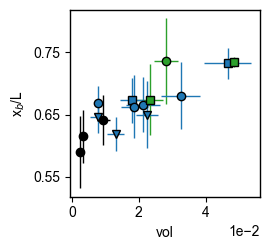

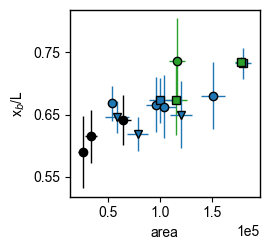

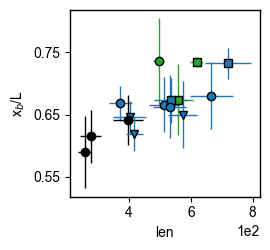

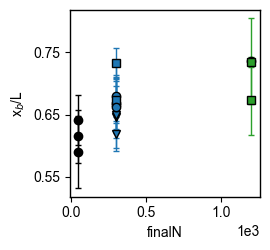

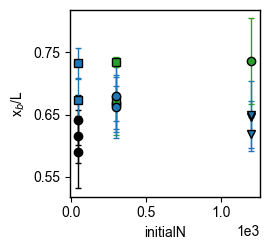

In [10]:
param = 'xb'   # 'ib', 'vol', 'area', 'len', 'finalN', 'initialN'

for param in ['vol', 'area', 'len', 'finalN', 'initialN']:
#for param in ['len']:
    plt.figure(figsize=(2.8,2.6))
    xs = list()
    ys = list()
    xs_mean = list()
    
    boundary_all = pd.DataFrame(columns=boundary_dicts['231030_BG06'].keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])

    for i, boundary_dict_c in enumerate(boundary_dicts.values()):
    
        boundary_df_c = pd.DataFrame(columns=boundary_dict_c.keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
    
        for k, v in boundary_dict_c.items():
        
            xb, ib, vol, area, length, final, initial, xb_raw = v
            boundary_df_c.loc['xb', k] = xb
            boundary_df_c.loc['ib', k] = ib
            boundary_df_c.loc['vol', k] = vol
            boundary_df_c.loc['area', k] = area
            boundary_df_c.loc['len', k] = length
            boundary_df_c.loc['finalN', k] = final
            boundary_df_c.loc['initialN', k] = initial
            boundary_df_c.loc['xb_raw', k] = xb_raw
            
            
        x_t120i = boundary_df_c.T['xb']
        v_t120i = boundary_df_c.T['vol']
        l_t120i = boundary_df_c.T['area']
    
        colors = [color_dict_sizes[c.split('-')[1]] for c in boundary_df_c.columns]
    
        for col in x_t120i.index:
            x = boundary_df_c.T['xb'][col]
            v = boundary_df_c.T[param][col]
            
            s = col.split('-')[1]
            m = 'o'
            
            if s in ['1200','300x4']:
                color = 'C02' 
            if s in ['300',  '1200/4', '50x6',]:
                color = 'C00'
            if s in ['50']:
                color = 'k'
                    
            if s in ['300x4', '50x6']:
                m = 's'    
            if s in ['1200/4']:
                m = 'v'
    
            capsize=0
            if 'N' in param:
                capsize=2

            plt.errorbar(np.nanmean(v), np.nanmean(x),yerr=np.nanstd(x), xerr=np.nanstd(v),
                         color=color,  marker=m, markeredgecolor='k', label=s, capsize=capsize)

            xs += list(x)
            ys += list(v)
            xs_mean.append(np.nanmean(x))
        
    ixnan = np.argwhere(np.isnan(xs)) 
    xs = np.array([xs[i] for i in range(len(xs)) if not i in ixnan])
    ys = np.array([ys[i] for i in range(len(ys)) if not i in ixnan]) 
    
    plt.xlabel(param)
    plt.ylabel(r'x$_b$/L')
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.yticks([0.55, 0.65, 0.75])

    plt.tight_layout()
    #plt.savefig(plots_path+ f'{chan}_xb_vs_{param}_mean_{t}_rect_initialColor_control.svg', dpi=200, transparent=True)
    plt.show()

Slope: 0.000193
R²: 0.22
R: 0.46


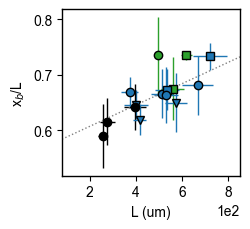

In [11]:
param = 'len'   # 'ib', 'vol', 'area', 'len', 'finalN', 'initialN'

plt.figure(figsize=(2.6,2.4))
xs = list()
ys = list()
xs_mean = list()

boundary_all = pd.DataFrame(columns=boundary_dicts['231030_BG06'].keys(), 
                                 index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
for i, boundary_dict_c in enumerate(boundary_dicts.values()):

    boundary_df_c = pd.DataFrame(columns=boundary_dict_c.keys(), 
                                 index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])

    for k, v in boundary_dict_c.items():
    
        xb, ib, vol, area, length, final, initial, xb_raw = v
        boundary_df_c.loc['xb', k] = xb
        boundary_df_c.loc['len', k] = length
        boundary_df_c.loc['vol', k] = vol
        boundary_df_c.loc['initialN', k] = initial
        
    x_t120i = boundary_df_c.T['xb']

    colors = [color_dict_sizes[c.split('-')[1]] for c in boundary_df_c.columns]

    for col in x_t120i.index:
        x = boundary_df_c.T['xb'][col]
        v = boundary_df_c.T[param][col]
        
        s = col.split('-')[1]
        m = 'o'

        if s in ['1200','300x4']:
            color = 'C02' 
        if s in ['300',  '1200/4', '50x6',]:
            color = 'C00'
        if s in ['50']:
            color = 'k'
                
        if s in ['300x4', '50x6']:
            m = 's'    
        if s in ['1200/4']:
            m = 'v'

        capsize=0
        if 'N' in param:
            capsize=2

        plt.errorbar(np.nanmean(v), np.nanmean(x),yerr=np.nanstd(x), xerr=np.nanstd(v),
                     color=color,  marker=m, markeredgecolor='k', label=s, capsize=capsize)

        xs += list(x)
        ys += list(v)
        xs_mean.append(np.nanmean(x))
    
ixnan = np.argwhere(np.isnan(xs)) 
xs = np.array([xs[i] for i in range(len(xs)) if not i in ixnan])
ys = np.array([ys[i] for i in range(len(ys)) if not i in ixnan]) 

slope, intercept, r_value, p_value, std_err = linregress(ys, xs)
xs_fit = slope * ys + intercept
xs_fit = slope * np.array([80, 850]) + intercept

plt.plot([80, 850], xs_fit, color='gray', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}', ls=':')

print(f"Slope: {slope:.6f}")
print(f"R²: {r_value**2:.2f}")
print(f"R: {r_value:.2f}")

plt.xlabel('L (um)')
plt.ylabel(r'x$_b$/L')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.xlim(80, 850)
plt.tight_layout()
#plt.savefig(plots_path+ f'{chan}_xbL_vs_{param}_mean_{t}_R2-{str(round(r_value**2, 2))[2:]}_m-{str(round(slope, 2))[2:]}.svg', dpi=200, transparent=True)
plt.show()

### Fig S8C,D

Scatter plots of mean total and relative pattern boundary positions ($x_b$ and $x_b/L$ respectively) of a channel (Foxc1, Bra, Sox2) at 120 h or 144 h versus different mean gastruloid morphological parameters for each condition across four batches.

Foxc1
Slope: 0.000179
R²: 0.177
R: 0.421


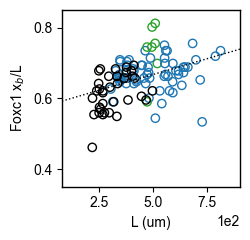

Slope no intercept forcing: 0.719
R²: 0.941
intercep -28.43284783910343

Slope with intercept forcing: 0.660
R²: 0.934


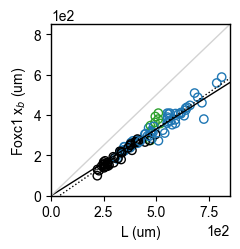

Bra
Slope: 0.000022
R²: 0.005
R: 0.071


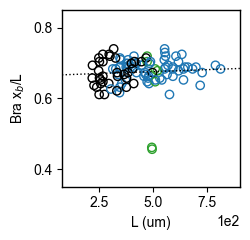

Slope no intercept forcing: 0.676
R²: 0.957
intercep -4.433418575691462

Slope with intercept forcing: 0.667
R²: 0.957


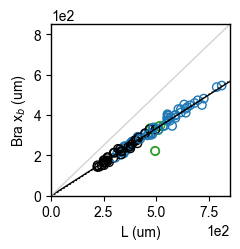

Sox2
Slope: 0.000128
R²: 0.103
R: 0.321


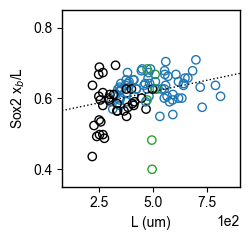

Slope no intercept forcing: 0.655
R²: 0.942
intercep -20.923883414346733

Slope with intercept forcing: 0.611
R²: 0.938


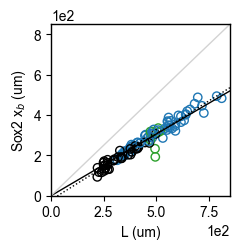

In [12]:
### all together 
dictionary_stats = {}


for chan in ['Foxc1', 'Bra', 'Sox2']:
    t = 120
    print(chan)
    dictionary_stats[chan] = {}
    exps = ['231030_BG06']
    boundary_dicts = dict()
    
    for exp in ['231030_BG06', '230903_Exp5_SlowImaging', '240202_size_50-1200','240205_size_50-1200']:
        exclude = ['3000']
        boundary_dict_c = {}
        entryN = 8
        
        df_OI, _ = pda.normalize_data_by_exp_mean(df_profiles_oriented, chan=chan, exp=exp, filter_cond=exclude)
        
        df_t = df_OI[df_OI['time']==t]
        for i, s in enumerate(sorted_groups):
            df_s = df_t[df_t['group'] == s]
            color = color_dict_sizes[str(s)]
            
            if len(df_s) < 3:
                continue
            
            ls = '-'
            if df_s['cut-fused'].unique()[0] == 'Yes':
                ls = ':'
            
            boundary_data = np.zeros((entryN, len(df_s)))
            for j, ix in enumerate(df_s.index):
                len_p = len(df_s.at[ix, f'{chan}_mean_exp_norm'])
                profile = df_s.at[ix, f'{chan}_mean_exp_norm'][int(0.1*len_p):-int(0.1*len_p)]
                
                nrm=5
                normed_m = np.convolve(profile, np.ones(nrm) / nrm, mode='valid')
                xbin = np.linspace(0.1, 0.9, len(profile))[2:-2]
                
                L = df_s.at[ix,'Length_MA_um']
                L_bin = len(df_s.at[ix,f'{chan}'])
                x_raw = np.linspace(0, L, L_bin)[int(0.1*L_bin):-int(0.1*L_bin)]
                
                xmin=0.1
                gradient_ch = 2
                if chan == 'Foxc1':
                    xmin=0.42
                    gradient_ch = -2
                
                try:
                    xboundary, Iboundary = pda.findboundary_extrema(normed_m, k=3, xmin=xmin, xmax=1, gradient=gradient_ch)               
                    
                    boundary_data[0, j] = xbin[int(np.nanmean(xboundary[0]))]
                    boundary_data[1, j] = Iboundary[0][0]
                    boundary_data[2, j] = df_s.at[ix, 'Volume_MA_mm3']
                    boundary_data[3, j] = df_s.at[ix, 'Area']*df_s.at[ix, 'um_per_pixel']**2
                    boundary_data[4, j] = df_s.at[ix, 'Length_MA_um']
                    boundary_data[5, j] = df_s.at[ix, 'final_size']
                    boundary_data[6, j] = initial_size_dict[df_s.at[ix, 'group']]
                    boundary_data[7, j] = x_raw[int(np.nanmean(xboundary[0]))]  
            
                except:
                    print(ix)
                    for k in range(entryN):
                        boundary_data[k, j] = np.nan 
    
            boundary_dict_c[f'{t}-{s}'] = boundary_data 
        boundary_dicts[exp] = boundary_dict_c



    param = 'len'   # 'ib', 'vol', 'area', 'len', 'finalN', 'initialN'
    #######
    plt.figure(figsize=(2.6,2.5))
    xs = list()
    ys = list()
    xs_mean = list()
    
    boundary_all = pd.DataFrame(columns=boundary_dicts['231030_BG06'].keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
    for i, boundary_dict_c in enumerate(boundary_dicts.values()):
    
        boundary_df_c = pd.DataFrame(columns=boundary_dict_c.keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
    
        for k, v in boundary_dict_c.items():
        
            xb, ib, vol, area, length, final, initial, xb_raw = v
            boundary_df_c.loc['xb', k] = xb
            boundary_df_c.loc['len', k] = length
            boundary_df_c.loc['vol', k] = vol
            boundary_df_c.loc['initialN', k] = initial
            
        x_t120i = boundary_df_c.T['xb']
    
        colors = [color_dict_sizes[c.split('-')[1]] for c in boundary_df_c.columns]
    
        for col in x_t120i.index:
            x = boundary_df_c.T['xb'][col]
            v = boundary_df_c.T[param][col]
            
            s = col.split('-')[1]
            m = 'o'
    
            if s in ['300x4', '1200/4', '50x6']:
                    continue
            
            if s in ['1200','300x4']:
                color = 'C02' 
            if s in ['300',  '1200/4', '50x6',]:
                color = 'C00'
            if s in ['50']:
                color = 'k'
                    
            if s in ['300x4', '50x6']:
                m = 's'    
            if s in ['1200/4']:
                m = 'v'
    
            capsize=0
            if 'N' in param:
                capsize=2
    
            plt.scatter(v, x, color=color,  marker=m,  label=s, facecolor='None')
    
            xs += list(x)
            ys += list(v)
            xs_mean.append(np.nanmean(x))
        
    ixnan = np.argwhere(np.isnan(xs)) 
    xs = np.array([xs[i] for i in range(len(xs)) if not i in ixnan])
    ys = np.array([ys[i] for i in range(len(ys)) if not i in ixnan]) 
    
    slope, intercept, r_value, p_value, std_err = linregress(ys, xs)
    xs_fit = slope * ys + intercept
    xs_fit = slope * np.array([80, 900]) + intercept
    
    plt.plot([80, 900], xs_fit, color='k', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}', ls=':')
    
    print(f"Slope: {slope:.6f}")
    print(f"R²: {r_value**2:.3f}")
    print(f"R: {r_value:.3f}")
    
    plt.xlabel('L (um)')
    plt.ylabel(rf'{chan} x$_b$/L')
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.xlim(80, 900)
    plt.ylim(0.35, 0.85)
    plt.yticks([0.4, 0.6, 0.8])
    plt.tight_layout()
    #plt.savefig(plots_path+ f'{chan}_xbL_vs_{param}_mean_{t}_individual.svg', dpi=200, transparent=True)
    plt.show()


    ################
    plt.figure(figsize=(2.5,2.6))
    xs = list()
    ys = list()
    xs_mean = list()
    
    boundary_all = pd.DataFrame(columns=boundary_dicts['231030_BG06'].keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
    for i, boundary_dict_c in enumerate(boundary_dicts.values()):
    
        boundary_df_c = pd.DataFrame(columns=boundary_dict_c.keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
    
        for k, v in boundary_dict_c.items():
        
            xb, ib, vol, area, length, final, initial, xb_raw = v
            boundary_df_c.loc['xb', k] = xb
            boundary_df_c.loc['ib', k] = ib
            boundary_df_c.loc['vol', k] = vol
            boundary_df_c.loc['area', k] = area
            boundary_df_c.loc['len', k] = length
            boundary_df_c.loc['finalN', k] = final
            boundary_df_c.loc['initialN', k] = initial
            boundary_df_c.loc['xb_raw', k] = xb_raw
            
            
        x_t120i = boundary_df_c.T['xb_raw']
        v_t120i = boundary_df_c.T['vol']
        l_t120i = boundary_df_c.T['area']
    
        colors = [color_dict_sizes[c.split('-')[1]] for c in boundary_df_c.columns]
    
        for col in x_t120i.index:
            x = boundary_df_c.T['xb_raw'][col]
            v = boundary_df_c.T[param][col]
        
            s = col.split('-')[1]
            m = 'o'
    
            if s in ['300x4', '1200/4', '50x6',]:
                    continue
            
            if s in ['1200','300x4']:
                color = 'C02' 
            if s in ['300',  '1200/4', '50x6',]:
                color = 'C00'
            if s in ['50']:
                color = 'k'
                    
            if s in ['300x4', '50x6']:
                m = 's'    
            if s in ['1200/4']:
                m = 'v'
    
            capsize=0
            if 'N' in param:
                capsize=2
    
            plt.scatter(v, x, color=color,  marker=m,  label=s, facecolor='None')
    
            xs += list(x)
            ys += list(v)
            xs_mean.append(np.nanmean(x))
        
    ixnan = np.argwhere(np.isnan(xs)) 
    xs = np.array([xs[i] for i in range(len(xs)) if not i in ixnan])
    ys = np.array([ys[i] for i in range(len(ys)) if not i in ixnan]) 
    
    slope, intercept, r_value, p_value, std_err = linregress(ys, xs)
    xs_fit = slope * ys + intercept
    xs_fit = slope * np.array([0, 850]) + intercept
    
    plt.plot([0, 850], xs_fit, color='k', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}', ls=':')
    
    print(f"Slope no intercept forcing: {slope:.3f}")
    print(f"R²: {r_value**2:.3f}")
    print('intercep', intercept)
    
    dictionary_stats[chan]['slope'] = slope 
    dictionary_stats[chan]["R"]= r_value
    dictionary_stats[chan]["R²"]= r_value**2
    dictionary_stats[chan]["intercept"]= intercept
    
    # Compute slope (line through origin)
    slope = np.sum(ys * xs) / np.sum(ys ** 2)
    xs_pred = slope * ys
    
    # R² calculation
    ss_tot = np.sum((xs - np.mean(xs)) ** 2)
    ss_res = np.sum((xs - xs_pred) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    xs_pred = slope * np.array([0,850])
    plt.plot(np.array([0,850]), xs_pred, label=f'Fit: y = {slope:.2f}x\n$R^2$ = {r_squared:.3f}', color='k')
    print(f"")
    print(f"Slope with intercept forcing: {slope:.3f}")
    print(f"R²: {r_squared:.3f}")
    
    dictionary_stats[chan]['slope_i'] = slope
    dictionary_stats[chan]["R_i"]= r_squared**0.5
    dictionary_stats[chan]["R²_i"]= r_squared
    dictionary_stats[chan]["intercept_i"]= 0
        
    plt.plot([0, 850], [0, 850], color='lightgray')
    plt.xlabel('L (um)')
    plt.ylabel(rf'{chan} x$_b$ (um)')
    plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    plt.xlim(0, 850)
    plt.ylim(0, 850)
    plt.tight_layout()

    #plt.savefig(plots_path+ f'{chan}_xb_vs_{param}_mean_{t}_individual.svg', dpi=200, transparent=True)
    plt.show()

In [13]:
pd.DataFrame(dictionary_stats)

,Foxc1,Bra,Sox2
slope,0.719262,0.675783,0.654681
R,0.970026,0.978220,0.970790
R²,0.940950,0.956914,0.942433
intercept,-28.432848,-4.433419,-20.923883
slope_i,0.660178,0.666571,0.611201
R_i,0.966430,0.978120,0.968439
R²_i,0.933987,0.956719,0.937874
intercept_i,0.000000,0.000000,0.000000


### Fig S8I

Scatter plots of mean relative pattern boundary positions ($x_b/L$) of a channel (Foxc1, Bra, Sox2) at 120 h or 144 h versus different mean gastruloid morphological parameters for each condition, color coded by the 4 different experimental batches. Error bars represent s.d. of 
and morphological parameter. 


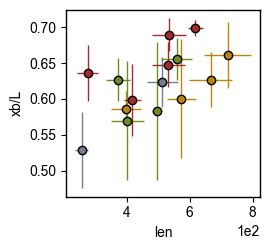

In [14]:
plt.figure(figsize=(2.8,2.6))
xs = list()
ys = list()
xs_mean = list()
param = 'len'
sig = 3

for i, (color, boundary_dict_c) in enumerate(zip(['slategray', 'olivedrab', 'darkgoldenrod', 'brown'], 
                                                 boundary_dicts.values())):

    boundary_df_c = pd.DataFrame(columns=boundary_dict_c.keys(), 
                                 index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])

    for k, v in boundary_dict_c.items():
    
        xb, ib, vol, area, length, final, initial, xb_raw = v
        boundary_df_c.loc['xb', k] = xb
        boundary_df_c.loc['ib', k] = ib
        boundary_df_c.loc['vol', k] = vol
        boundary_df_c.loc['area', k] = area
        boundary_df_c.loc['len', k] = length
        boundary_df_c.loc['finalN', k] = final
        boundary_df_c.loc['initialN', k] = initial
        
        
    x_t120i = boundary_df_c.T['xb']
    v_t120i = boundary_df_c.T['vol']
    l_t120i = boundary_df_c.T['area']

    colors = [color_dict_sizes[c.split('-')[1]] for c in boundary_df_c.columns]

    for col in x_t120i.index:
        x = boundary_df_c.T['xb'][col]
        v = boundary_df_c.T[param][col]
        
        s = col.split('-')[1]
        
        m = 'o'
        
        sig3up = np.nanmean(x) + sig*np.nanstd(x)
        sig3down = np.nanmean(x) - sig*np.nanstd(x)
        mask =  x < sig3up
        mask *= sig3down < x
        x_f = x*mask
        v_f = v*mask
            
        ixnonzero = np.nonzero(x_f)
        x_f = np.array([x_f[i] for i in range(len(x_f)) if i in ixnonzero[0]])
        v_f = np.array([v_f[i] for i in range(len(v_f)) if i in ixnonzero[0]])
        
        ixnonzero = np.nonzero(v_f)
        x_f = np.array([x_f[i] for i in range(len(x_f)) if i in ixnonzero[0]])
        v_f = np.array([v_f[i] for i in range(len(v_f)) if i in ixnonzero[0]])
        
    
        xs += list(x_f)
        ys += list(v_f)        
        
        plt.errorbar(np.nanmean(v_f), np.nanmean(x_f),yerr=np.nanstd(x_f), xerr=np.nanstd(v_f), color=color, 
                    markeredgecolor='k', marker=m, label=s)

        xs_mean.append(np.nanmean(x_f))
        
ixnan = np.argwhere(np.isnan(xs)) 
xs = np.array([xs[i] for i in range(len(xs)) if not i in ixnan])
ys = np.array([ys[i] for i in range(len(ys)) if not i in ixnan]) 

plt.xlabel(param)
plt.ylabel('xb/L')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

#plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig(plots_path+ f'{chan}_xb_vs_{param}_mean_{t}_exp_color.svg', dpi=200, transparent=True)
plt.show()

### Check if data from other experiments matches the trend

In [15]:
df_other = pd.read_json(raw_data_folder+'data/df_IF_small_new_markers.json', orient='split')

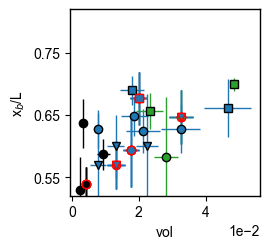

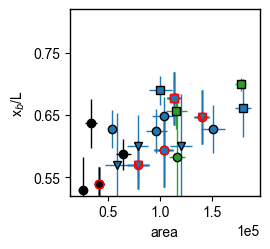

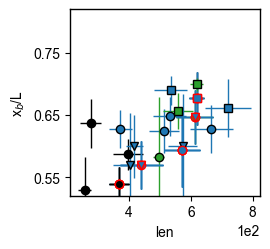

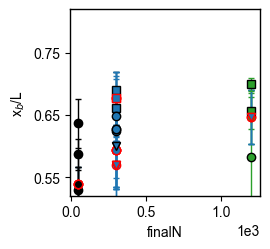

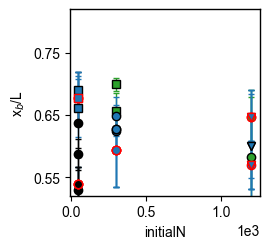

In [16]:
param = 'xb'   # 'ib', 'vol', 'area', 'len', 'finalN', 'initialN'

for param in ['vol', 'area', 'len', 'finalN', 'initialN']:
#for param in ['len']:
    plt.figure(figsize=(2.8,2.6))
    xs = list()
    ys = list()
    xs_mean = list()
    
    boundary_all = pd.DataFrame(columns=boundary_dicts['231030_BG06'].keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])

    for i, boundary_dict_c in enumerate(boundary_dicts.values()):
    
        boundary_df_c = pd.DataFrame(columns=boundary_dict_c.keys(), 
                                     index=['xb', 'ib', 'vol', 'area', 'len', 'finalN', 'initialN', 'xb_raw'])
    
        for k, v in boundary_dict_c.items():
        
            xb, ib, vol, area, length, final, initial, xb_raw = v
            boundary_df_c.loc['xb', k] = xb
            boundary_df_c.loc['ib', k] = ib
            boundary_df_c.loc['vol', k] = vol
            boundary_df_c.loc['area', k] = area
            boundary_df_c.loc['len', k] = length
            boundary_df_c.loc['finalN', k] = final
            boundary_df_c.loc['initialN', k] = initial
            boundary_df_c.loc['xb_raw', k] = xb_raw
            
            
        x_t120i = boundary_df_c.T['xb']
        v_t120i = boundary_df_c.T['vol']
        l_t120i = boundary_df_c.T['area']
    
        colors = [color_dict_sizes[c.split('-')[1]] for c in boundary_df_c.columns]
    
        for col in ['120-50', '120-50x6', '120-300', '120-1200/4', '120-1200', '120-300x4']:
            try:
                v = boundary_df_c.T['xb'][col]
                x = boundary_df_c.T[param][col]
                
                s = col.split('-')[1]
                m = 'o'
                
                if s in ['1200','300x4',]:
                    color = 'C02' 
                if s in ['300',   '1200/4','50x6',]:
                    color = 'C00'
                if s in ['50', ]:
                    color = 'k'
                        
                if s in ['300x4', '50x6']:
                    m = 's'    
                if s in ['1200/4']:
                    m = 'v'
        
                capsize=0
                if 'N' in param:
                    capsize=2
    
                plt.errorbar(np.nanmean(x), np.nanmean(v),yerr=np.nanstd(v), xerr=np.nanstd(x),
                             color=color,  marker=m, markeredgecolor='k', label=s, capsize=capsize)
            except:
                a=2

            try:
                v2 = df_other.T['xb'][col]
                x2 = df_other.T[param][col]
                
                plt.errorbar(np.nanmean(x2), np.nanmean(v2),yerr=np.nanstd(v2), xerr=np.nanstd(x2),
                             color=color,  marker=m, markeredgecolor='red', label=s, capsize=capsize)
            except:
                a = 1

            xs += list(x)
            ys += list(v)
            xs_mean.append(np.nanmean(x))
        
    ixnan = np.argwhere(np.isnan(xs)) 
    plt.xlabel(param)
    plt.ylabel(r'x$_b$/L')
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.yticks([0.55, 0.65, 0.75])
    
    plt.ylim(0.52, 0.82)
    #plt.xlim(190,850)
    plt.tight_layout()
    plt.show()